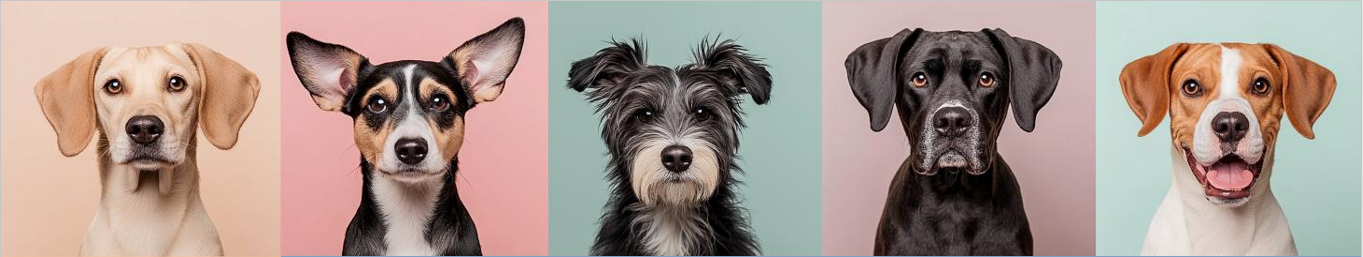

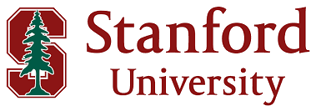

# Notebook 2 - Entraînement d'un modèle personnel

# Contexte

Je suis bénévole pour l'association de protection des animaux de mon quartier, Le Refuge. <br/>
L'association aurait besoin d'aide pour mettre à jour sa base de données de pensionnaires.<br/>
L'objectif de ce projet est de leur proposer un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.<br/>

Les étapes que nous allons suivre :<br/>
- **Pré-processer les images** avec des techniques spécifiques *(e.g. whitening, equalization, éventuellement modification de la taille des images)*.<br/>
- Réaliser une **data augmentation** *(mirroring, cropping...)*.<br/>
- Mettre en oeuvre de 2 approches de CNN :<br/>
    - Réaliser notre propre réseau de neurones CNN en optimisant les paramètres.   <br/>  
    - Utiliser le transfert learning.<br/>

**Données disponibles** :<br/>
Un repo Git est disponible pour ce projet à l'adreshttps://github.com/JustineJa/OC_IML_P6n<br/>
Les données sources pour entraîner notre modèle se trouvent ici : http://vision.stanford.edu/aditya86/ImageNetDogs/..com/

<h1><span style="color:#343434" id="sommaire">Sommaire</span></h1>

1. [Preprocessing des images](#section_1)
 
    1.1. [Visualisation de la liste des races (classes) et un exemple de données](#section_1_1)         
    1.6. [Fonction de traitement par lot pour le preprocessing](#section_1_6)

3. [Modèle CNN personnel](#section_2)

    2.1. [Préparation des données](#section_2_1) <br/>
    2.2. [Construction du modèle CNN](#section_2_2)<br/>
    2.3. [Entrainement et évaluation du modèle CNN](#section_2_3)<br/>
    2.4. [Evaluation du modèle](#section_2_4)<br/>
    2.5. [Sauvegarde sur MLFlow](#section_2_5)<br/>

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# <span style="color:#343434" id="section_1">1. Preprocessing des images</span>

Tout d'abord, nous allons rapidement analyser les données :

## <span style="color:#343434" id="section_1_1">1.1. Visualisation de la liste des races *(nos classes)* et un exemple de données.</span>

In [4]:
# Define path to data
annotations_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Annotation' 
images_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Images'

In [5]:
# Count the number of classes (dogs breeds)
list_races = os.listdir(images_dir)
print(f"Il y a {len(list_races)} races dans le dataset")

Il y a 120 races dans le dataset


120 races de chien sont donc présentes dans notre jeu de données, ce qui représente **120 classes**.<br/>
Nous allons compter le nombre d'images par race pour contrôler la distribution :

Nous allons conserver les 4 races les plus "fournies" en photos + les bulledogs français : 

In [6]:
list_races = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 
              'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02108915-French_bulldog']

In [7]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

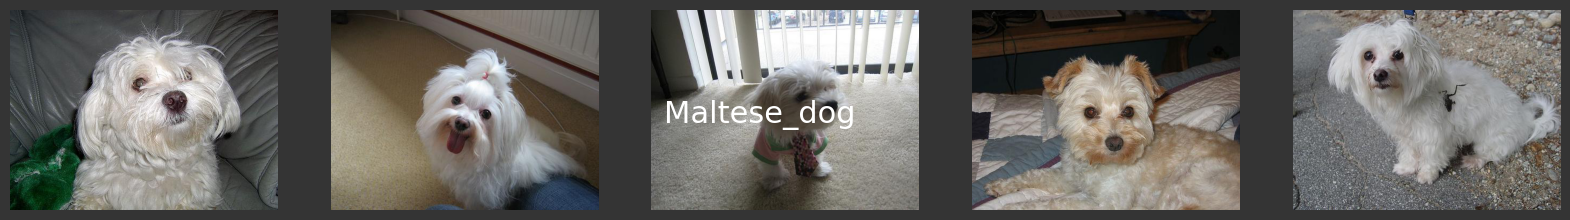

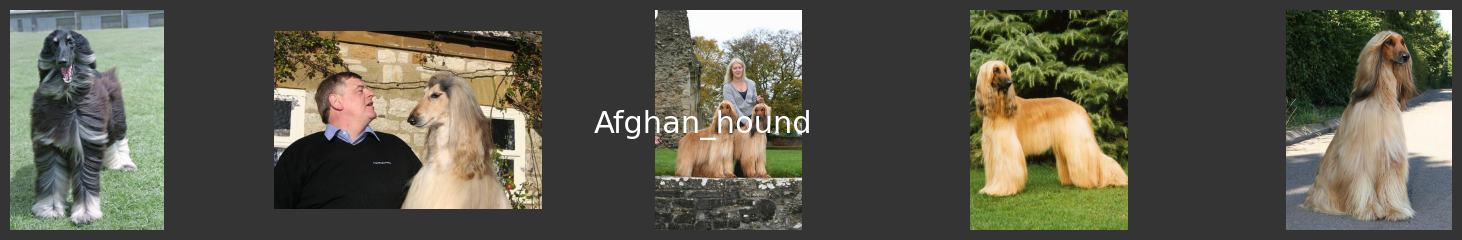

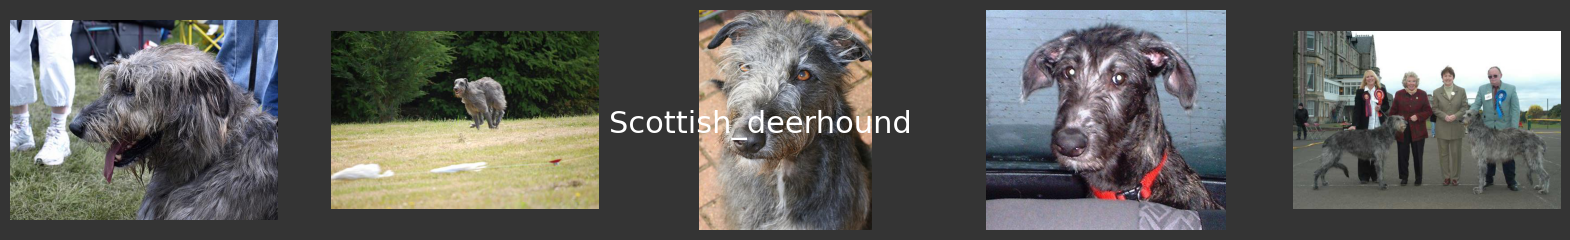

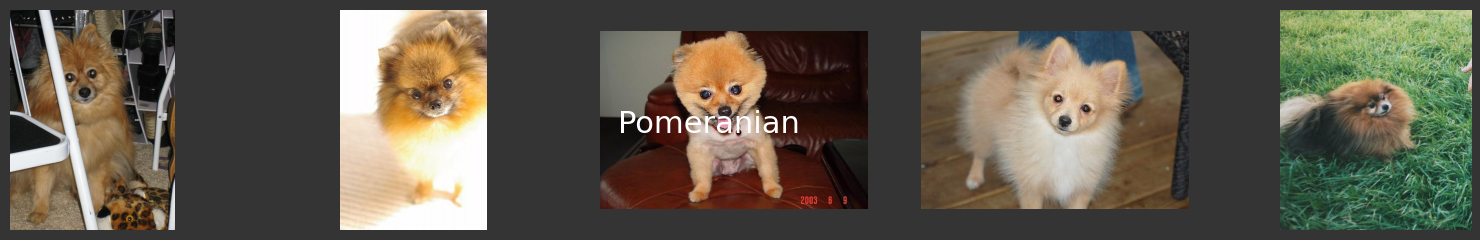

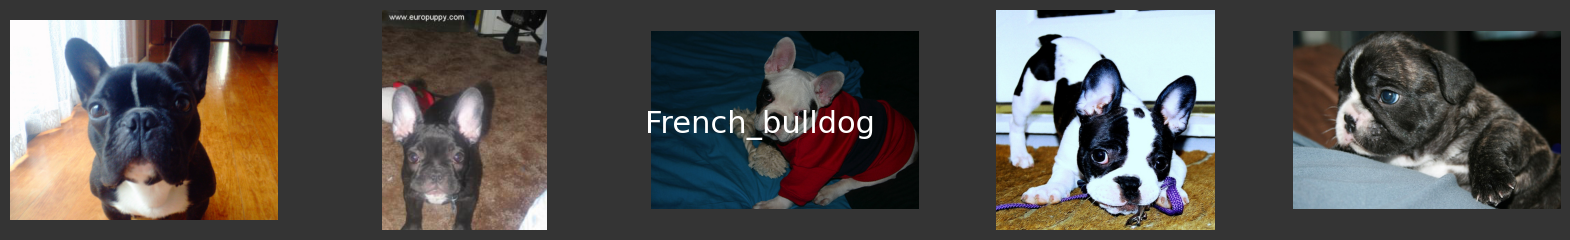

In [8]:
for i in list_races:
    show_images_classes(images_dir, i, 5)

## <span style="color:#343434" id="section_1_6">1.6. Fonction de traitement par lot pour le preprocessing</span>

Nous allons déjà tester les fonctions et la classification sur un nombre restreint de race de chien afin de limiter les temps de calcul. Constuisons la fonction de preprocessing qui retournera les labels et images :

In [9]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)

            # Whitening transformation
            whitened_image = dst_img
            #whitened_image = image_whitening(dst_img)
            
            
            # Convert modified img to array
            img_array = image.img_to_array(whitened_image)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

Nous allons créer et entrainer les modèles sur **5 races de chiens**. 

Cet algorithme pourra ensuite être étendu à l'ensemble des races s'il est satisfaisant.

In [10]:
# Define numbers of breeds to preprocess
nb_races = len(list_races) 
# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(list_races, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time

print("-" * 50)
print("Nombre d'images préprocessées : {}"\
     .format(len(y)))
print("Taille des images np.array : {}"\
     .format(X.shape))
print("Temps total : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Nombre d'images préprocessées : 1101
Taille des images np.array : (1101, 299, 299, 3)
Temps total : 555.85s


In [11]:
y[1000]

'French_bulldog'

In [12]:
list_races

['n02085936-Maltese_dog',
 'n02088094-Afghan_hound',
 'n02092002-Scottish_deerhound',
 'n02112018-Pomeranian',
 'n02108915-French_bulldog']

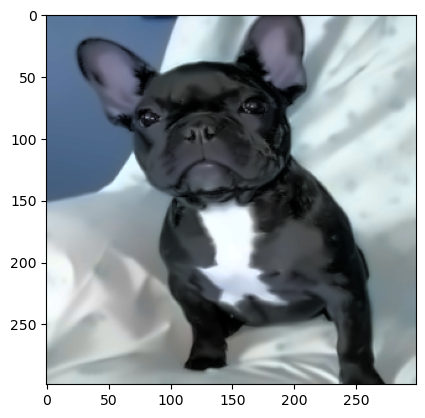

In [13]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1000]))

# <span style="color:#343434" id="section_2">2. Modèle CNN personnel</span>

## <span style="color:#343434" id="section_2_1">2.1. Préparation des données</span>
Mélanger les images pour que les photos de même race ne se suivent.

In [14]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

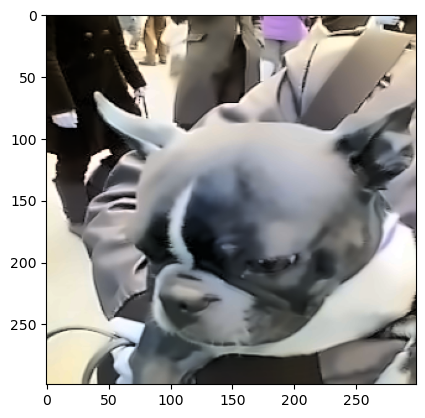

In [15]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1000]))

**Préparation des données pour l'input dans keras :** 
- X -> float
- y -> encodage numérique des donnéees textuelles (races de chien) => LabelEncoder

In [16]:
X.shape

(1101, 299, 299, 3)

In [17]:
# Change X type 
#X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [18]:
# Verifie encoder created classes
print(encoder.classes_)

['Afghan_hound' 'French_bulldog' 'Maltese_dog' 'Pomeranian'
 'Scottish_deerhound']


In [19]:
mylist2 = set(y)
mylist2 = list(mylist2)
print(mylist2)

[0, 1, 2, 3, 4]


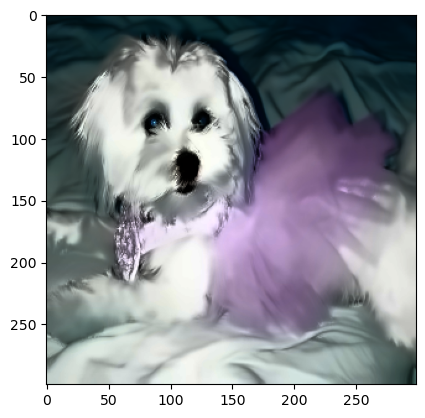

In [20]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[500]))

In [21]:
y[500]

2

Création set **entraînement et validation**. 

Le set de **validation** quant à lui sera créé dans le générateur Keras.

In [22]:
### Create train and test set
# Split data into training (80%), testing (10%), and validation (10%) sets
x_train, x_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=y
                                                   )
x_test, x_val, y_test, y_val = train_test_split(x_temp, 
                                                y_temp, 
                                                test_size=0.4, 
                                                random_state=42, 
                                                stratify=y_temp
                                               )

print("-" * 50)
print("Taille des sets :")
print("-" * 50)
print("Train set = ",x_train.shape[0])
print("Test set = ",x_test.shape[0])
print("Validation set = ",x_val.shape[0])

--------------------------------------------------
Taille des sets :
--------------------------------------------------
Train set =  825
Test set =  165
Validation set =  111


Dernière étape de la préparation, nous allons **créer les générateurs Keras** pour les sets de données en incluant la **Data Augmentation pour le jeu d'entrainement** :

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [23]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

## <span style="color:#343434" id="section_2_2">2.2. Construction du modèle CNN</span>

In [24]:
train_datagen.fit(x_train)

In [43]:
height = X.shape[1]
width = X.shape[2]
num_classes = nb_races

# Define the model
model = Sequential()

# Input layer and first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)))  # height and width should be set based on your data
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# First fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Second fully connected layer
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Third fully connected layer
model.add(Dense(32, activation='relu'))

# Output layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))  # num_classes should be set based on the number of classes in your problem

Ajoute la condition d'early stopping :

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [45]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Compile the model
optimizer = "adam"
#optimizer = 'SGD'
loss = 'sparse_categorical_crossentropy'

model.compile(optimizer=optimizer,
              loss=loss,  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

In [46]:
# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 297, 297, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 156800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      20,070,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,168,069 (76.94 MB)

 Trainable params: 20,168,069 (76.94 MB)

 Non-trainable params: 0 (0.00 B)

Notre modèle est créé, nous allons pouvoir l'**entrainer sur 50 époques grâce aux générateur précédement créés et stocker les résultats** pour ensuite les analyser :

## <span style="color:#343434" id="section_2_3">2.3. Entrainement et évaluation du modèle CNN</span>

In [ ]:
nb_epoch = 30

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) // 32,
                    epochs=nb_epoch,
                    validation_data=(x_val, y_val),
                   callbacks=[early_stop]
                   )

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.2229 - loss: 2.0011 - val_accuracy: 0.3333 - val_loss: 27.8542
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1875 - loss: 1.6185 - val_accuracy: 0.3153 - val_loss: 23.5226
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 616ms/step - accuracy: 0.2376 - loss: 1.6097 - val_accuracy: 0.2072 - val_loss: 19.5827
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3438 - loss: 1.5689 - val_accuracy: 0.2072 - val_loss: 21.9666
Epoch 5/30
10/25 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.2299 - loss: 1.5888 

In [ ]:
# Save the model
model.save('scratch_model.h5')
print("Model saved.")

## <span style="color:#343434" id="section_2_3">2.4. Evaluation du modèle</span>

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

In [ ]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

In [ ]:
# Assuming you have 'history' from your model training
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Matrice de confusion

In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)
confusion_matrix(y_test, pred)

In [ ]:
pd.Series(y_test).value_counts()

In [ ]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize = (18, 8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = encoder.classes_)
disp.plot(ax = ax)
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")

In [ ]:
pred

## <span style="color:#343434" id="section_2_5">2.5. Sauvegarde sur MLFlow</span>

In [ ]:
import mlflow

model_name = "scratch"
split = "75/15/10"
couches = "2 denses"
nom_complet = model_name+" - "+split

mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Ensure this matches the port where the server is running

# Define experiment name and description
experiment_name = "IML P6 Scratch"
mlflow.set_experiment(experiment_name)# Start MLflow run
experiment_description = nom_complet

In [ ]:
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_param("Nom test", nom_complet)
    #mlflow.log_param("batch_size", 100)
    mlflow.log_param("epochs", nb_epoch)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("Nb denses", couches)
    mlflow.log_param("callbacks", [early_stop])
    
    # Evaluate model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", accuracy)

    # Infer the model signature
    #signature = infer_signature(x_train, model.predict(x_train))
    
    # Log model
    mlflow.keras.log_model(model, nom_complet)

print("Model training and logging complete!")